In [87]:
import pandas as pd
import folium
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
import umap
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

sys.path.append(os.path.abspath('..')) 

from utils.preproc_utils import *
from utils.plot_utils import *
from utils.modeling_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
sys.path.append(os.path.abspath('..')) 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/processed/'))

preproc_path = os.path.join(base_dir, 'customer_info_preproc.csv')
customer_info_preproc = pd.read_csv(preproc_path, index_col='customer_id')

### **Clustering**

In [93]:
umap_reducer = umap.UMAP(n_neighbors=35, min_dist=0.0, n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(customer_info_preproc)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


C:\Users\vic\AppData\Local\Temp\ipykernel_36444\2766612558.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='UMAP1', y='UMAP2', data=embeddings_df, palette='tab10')


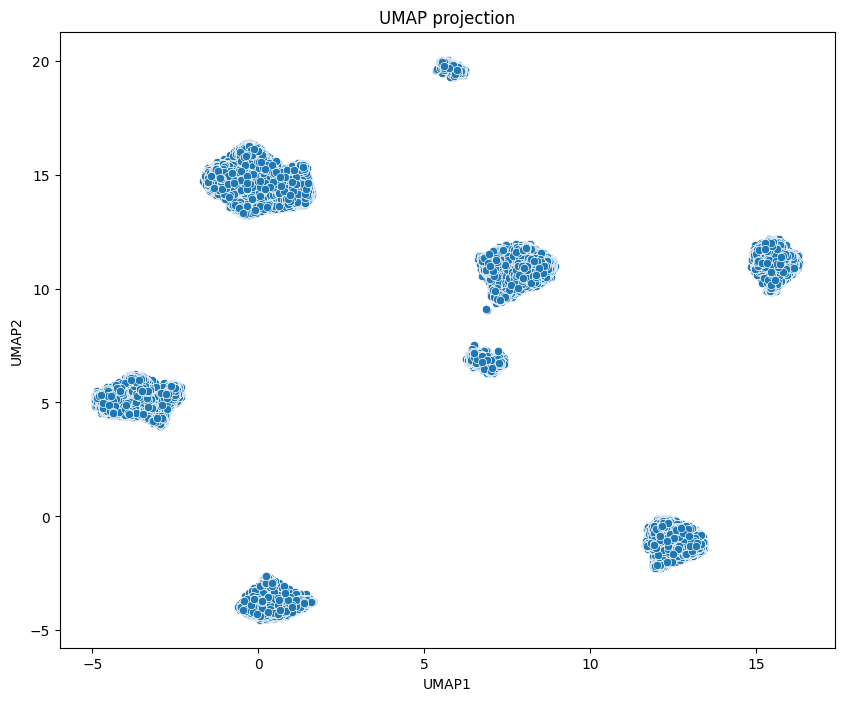

In [95]:
embeddings_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', data=embeddings_df, palette='tab10')
plt.title('UMAP projection')
plt.show()

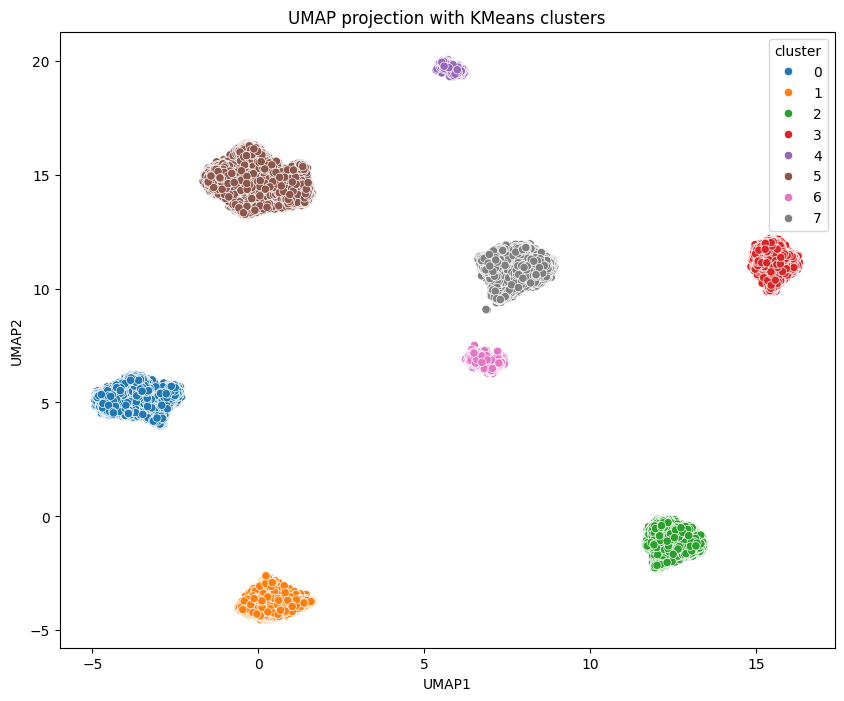

In [109]:
hdbscan = HDBSCAN(min_cluster_size=150, min_samples=10, cluster_selection_epsilon=1.4)
hdbscan_labels = hdbscan.fit_predict(umap_embeddings)

umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'], index=customer_info_preproc.index)
umap_df['cluster'] = hdbscan_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=umap_df, palette='tab10')
plt.title('UMAP projection with KMeans clusters')
plt.show()

In [110]:
cluster_counts = umap_df['cluster'].value_counts()
cluster_counts = cluster_counts.sort_index()
cluster_counts

0     7086
1     4241
2     5642
3     4955
4     1108
5    10833
6     2281
7     7097
Name: cluster, dtype: int64

### **Exporting the Clusters**

In [105]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/processed/'))
fishy_outliers = pd.read_csv(os.path.join(base_dir, 'fishy_outliers.csv'), index_col='customer_id')

fishy_outliers['cluster'] = (max(umap_df['cluster']) + 1) * np.ones(fishy_outliers.shape[0])

In [106]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/raw/'))
customer_info = pd.read_csv(os.path.join(base_dir, 'customer_info.csv'), index_col='customer_id')

customer_info_clean = clean_customer_data(customer_info)

customer_info_clean = feat_engineering(customer_info_clean)

customer_info_clean_labeled = pd.merge(customer_info_clean, umap_df['cluster'], how='left', on='customer_id')

# merge fishy_outliers and fill missing clusters with the information from fishy_outliers
customer_info_clean_labeled = pd.merge(customer_info_clean_labeled, fishy_outliers[['cluster']], how='left', on='customer_id', suffixes=('', '_fishy'))

# combine cluster labels
customer_info_clean_labeled['cluster'] = customer_info_clean_labeled['cluster'].combine_first(customer_info_clean_labeled['cluster_fishy'])

customer_info_clean_labeled.drop(columns=['cluster_fishy'], inplace=True)

export_clusters(customer_info_clean_labeled, 'cluster')

## **Visualizing the Clusters**

In [128]:
# statistics by cluster

cluster_mapping = {
    0: 'Veggies',
    1: 'Pet Owners',
    2: 'Tech Enthusiasts',
    3: 'Loyal Customers',
    4: 'Student Alcoholics',
    5: 'Promo Hunters',
    6: 'Young Adults',
    7: 'Parents',
    8: 'Fishies'
}

spend_cols = ['spend_groceries', 'spend_electronics', 'spend_vegetables', 
                  'spend_nonalcohol_drinks', 'spend_alcohol_drinks', 'spend_meat', 
                  'spend_fish', 'spend_hygiene', 'spend_videogames', 'spend_petfood']

customer_info_clean_labeled['cluster'] = customer_info_clean_labeled['cluster'].replace(cluster_mapping)

cluster_stats = customer_info_clean_labeled.drop(columns=spend_cols, axis=1).groupby('cluster').mean().T
cluster_stats

cluster                                       Fishies  Loyal Customers  \
kids_home                                    0.023560         0.995925   
teens_home                                   0.031250         0.821296   
number_complaints                            0.506562         1.002046   
distinct_stores_visited                      1.000000         2.012703   
typical_hour                                10.013405         9.486225   
total_distinct_products                     19.881443      1058.893239   
percentage_of_products_bought_promotion      0.397338         0.200963   
age                                         53.817010        54.187689   
loyalty_member                               0.798969         0.800202   
years_as_customer                           12.737113        15.349142   
educ_years                                  12.048969        13.616953   
gender_binary                                0.510309         0.503532   
frequency                                    2.342784         2.304339   
monetary                                 54233.445876     16990.448840   
spend_groceries_proportion                   0.267163         0.293905   
spend_electronics_proportion                 0.003692         0.120516   
spend_vegetables_proportion                  0.007822         0.017757   
spend_nonalcohol_drinks_proportion           0.005961         0.035644   
spend_alcohol_drinks_proportion              0.001927         0.059810   
spend_meat_proportion                        0.001683         0.059222   
spend_fish_proportion                        0.726777         0.118080   
spend_hygiene_proportion                     0.001953         0.119865   
spend_videogames_proportion                  0.000000         0.059708   
spend_petfood_proportion                     0.000000         0.119664   
has_offspring                                0.054124         0.926539   
has_complaints                               0.000000         0.002422   
has_educ                                     0.010309         0.299697   

cluster                                       Parents    Pet Owners  \
kids_home                                    3.053345      0.000000   
teens_home                                   1.992775      0.011813   
number_complaints                            0.993571      0.505271   
distinct_stores_visited                      1.123451      1.000000   
typical_hour                                17.574599     11.858968   
total_distinct_products                    513.897562     51.709502   
percentage_of_products_bought_promotion      0.198461      0.197791   
age                                         54.525433     54.771752   
loyalty_member                               0.597295      0.199953   
years_as_customer                           12.892067     12.946475   
educ_years                                  13.052417     12.000000   
gender_binary                                0.492603      0.494223   
frequency                                    2.292095      0.000000   
monetary                                 13339.695928  21527.461448   
spend_groceries_proportion                   0.378141      0.460985   
spend_electronics_proportion                 0.147903      0.007844   
spend_vegetables_proportion                  0.037918      0.009832   
spend_nonalcohol_drinks_proportion           0.038181      0.024579   
spend_alcohol_drinks_proportion              0.022888      0.001982   
spend_meat_proportion                        0.075618      0.009969   
spend_fish_proportion                        0.075998      0.010014   
spend_hygiene_proportion                     0.075332      0.003899   
spend_videogames_proportion                  0.075505      0.000000   
spend_petfood_proportion                     0.075610      0.471413   
has_offspring                                0.957447      0.011318   
has_complaints                               0.000705      0.000000   
has_educ  

In [118]:
only_id_and_cluster = customer_info_clean_labeled['cluster']

base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/clusters/'))

only_id_and_cluster.to_csv(os.path.join(base_dir, 'cluster_labels.csv'))

In [132]:
customer_info_clean_labeled_location = pd.merge(customer_info_clean_labeled, customer_info[['latitude', 'longitude']], how='left', on='customer_id')

plot_cluster(customer_info_clean_labeled_location, 'Tech Enthusiasts')

In [113]:
cluster_counts = customer_info_clean_labeled['cluster'].value_counts()
cluster_counts = cluster_counts.sort_index()
cluster_counts

0.0     7086
1.0     4241
2.0     5642
3.0     4955
4.0     1108
5.0    10833
6.0     2281
7.0     7097
8.0      388
Name: cluster, dtype: int64

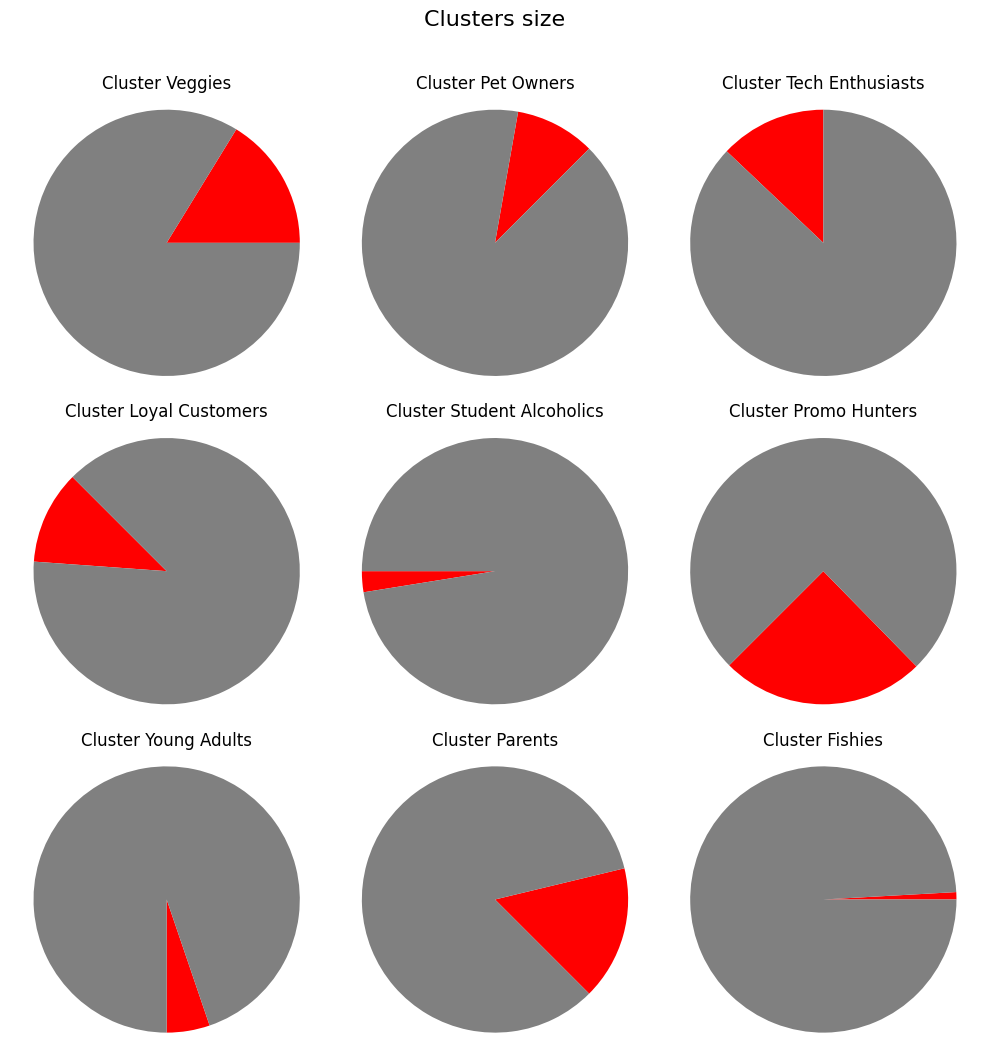

In [115]:
total_rows = len(customer_info_clean_labeled)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

start_angles = [0, 45, 90, 135, 180, 225, 270, 315, 360]

clusters = {'Veggies': 0, 
            'Pet Owners': 1, 
            'Tech Enthusiasts': 2, 
            'Loyal Customers': 3, 
            'Student Alcoholics': 4, 
            'Promo Hunters': 5, 
            'Young Adults': 6, 
            'Parents': 7, 
            'Fishies': 8
            }

for name, i in clusters.items():
    count = cluster_counts.get(i, 0)
    sizes = [count, total_rows - count]
    colors = ['red', 'grey']
    axes[i].pie(sizes, colors=colors, startangle=start_angles[i])
    axes[i].set_title(f'Cluster {name}')
    axes[i].axis('equal')

plt.tight_layout()
plt.suptitle('Clusters size', fontsize=16, y=1.05)

plt.show()